"""
*****************************************************************************
* MLops                                                      *
* OBJETIVO: Preprocesamiento del modelo vinos                               * 
* INPUT: vinos.csv                         *
* OUTPUT: DATA_VINOS_PREPROCESAMIENTO.parquet                       *
* FECHA CREACION: 05/12/2024                                                *
* ***************************************************************************
* MODIFICACIONES
* NOMBRE WUILSON ESTACIO                    
* FECHA 05/12/2024
* VERSION 02
* DESCRIPCION Realiza Preprocesamiento del modelo y empaque 
******************************************************************************
"""

### Instalacion Librerias requeridas

In [1]:
# Lista de librerías a instalar
# Instalar librerias
import subprocess
librerias = ['pyspark','jedi','seaborn']

# Iterar sobre la lista de librerías y ejecutar el comando de instalación para cada una
for libreria in librerias:
    subprocess.run(['pip', 'install', libreria])

In [2]:
%config IPCompleter.greedy=True

## Librerias

In [3]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, expr, asc, count, countDistinct, max, collect_list, sum, isnan, isnull, last
from pyspark.sql.functions import col as col_null
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, DateType
# Importar bibliotecas para normalización 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [4]:
# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("MiAplicacion") \
    .getOrCreate()

24/12/06 20:47:04 WARN Utils: Your hostname, cluster-ml-wilson resolves to a loopback address: 127.0.0.1; using 10.0.0.4 instead (on interface eth0)
24/12/06 20:47:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/06 20:47:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/06 20:47:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/06 20:47:05 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Carga de Funciones

In [5]:
# Obtener la ruta absoluta del directorio actual
directorio_actual = os.path.abspath(os.getcwd())

# Calcular la ruta de la carpeta 'Funciones' en función de la ubicación actual
ruta_funciones = os.path.abspath(os.path.join(directorio_actual, '../Funciones'))

In [6]:
# Añadir la ruta al sys.path para importar el módulo
sys.path.append(ruta_funciones)

In [8]:
# Importar todas las funciones para realizar el EDA adquisición
import sys
# sys.path.append("../Funciones/")

from FN_01_LIMPIEZA_ADQUISICION import FN_TRANSFORMAR_TIPOS_DATOS
from FN_01_LIMPIEZA_ADQUISICION import FN_IDENTIFICAR_COLUMNAS_NULAS
from FN_01_LIMPIEZA_ADQUISICION import FN_PLOT_TARGET_DISTRIBUCION
from FN_01_LIMPIEZA_ADQUISICION import FN_PLOT_VARIABLE_DISTRIBUCION_POR_TARGET
from FN_01_LIMPIEZA_ADQUISICION import FN_ENCODE_COLUMNAS_CATEGORICAS
from FN_01_LIMPIEZA_ADQUISICION import FN_ESCALAR_DATOS
from FN_01_LIMPIEZA_ADQUISICION import FN_PLOT_VARIABLES_CORRELACION_CON_TARGET
from FN_01_LIMPIEZA_ADQUISICION import FN_PLOT_MATRIZ_CORRELACION
from FN_01_LIMPIEZA_ADQUISICION import FN_CALCULAR_MODA_Y_REEMPLAZAR_NULOS
# from FN_01_LIMPIEZA_ADQUISICION import FN_FFILL_LLENAR_NULOS

### Lectura de Data

In [9]:
## Lectura de data
ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("vinos", version="1")

df = pd.read_csv(data_asset.path, sep=';')
# df = spark.read.csv(data_asset.path, sep=';', header=True,inferSchema=True) # se queria leeer en pyspark por cuestiones de nuevo ambiente no permitio
df = spark.createDataFrame(df)
df.show()

Found the config file in: /config.json


+------+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+-------------------+-------+
|Target|Alcohol|Malic_acid| Ash|Alcalinity_of_ash|Magnesium|Total_phenols|Flavanoids|Nonflavanoid_phenols|Proanthocyanins|Color_intensity| Hue|OD315_diluted_wines|Proline|
+------+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+-------------------+-------+
|     1|  14.23|      1.71|2.43|             15.6|      127|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|               3.92|   1065|
|     1|   13.2|      1.78|2.14|             11.2|      100|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|                3.4|   1050|
|     1|  13.16|      2.36|2.67|             18.6|      101|          2.8|      3.24|                 0.3|           2.81|           5.68|1.

### Verificacion de columnas y filas de la data

In [10]:
# Número de filas
num_filas = df.count()
# Número de columnas
num_columnas = len(df.columns)
# Mostrar resultados
print(f"Número de filas: {num_filas}")
print(f"Número de columnas: {num_columnas}")

Número de filas: 178
Número de columnas: 14


### Deteccion de anomalias

In [11]:
# Detectar columnas con valores infinitos
columnas_con_infinito = {}

for columna in df.columns:
    # Crear una condición para identificar valores infinitos
    inf_condition = (col(columna) == float("inf")) | (col(columna) == float("-inf"))
    
    # Contar los valores infinitos en cada columna
    num_inf = df.select(count(when(inf_condition, 1)).alias("num_inf")).collect()[0]["num_inf"]
    
    if num_inf > 0:
        columnas_con_infinito[columna] = num_inf

# Mostrar resultado
if columnas_con_infinito:
    print("Columnas con valores infinitos:")
    for columna, cantidad in columnas_con_infinito.items():
        print(f"- {columna}: {cantidad} valores infinitos")
else:
    print("No se encontraron valores infinitos en ninguna columna.")

    print("No se encontraron valores infinitos en ninguna columna.")

No se encontraron valores infinitos en ninguna columna.
No se encontraron valores infinitos en ninguna columna.


In [12]:
# Visualizar tipo de datos que tiene cada columna 
df.printSchema()

root
 |-- Target: long (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- Malic_acid: double (nullable = true)
 |-- Ash: double (nullable = true)
 |-- Alcalinity_of_ash: double (nullable = true)
 |-- Magnesium: long (nullable = true)
 |-- Total_phenols: double (nullable = true)
 |-- Flavanoids: double (nullable = true)
 |-- Nonflavanoid_phenols: double (nullable = true)
 |-- Proanthocyanins: double (nullable = true)
 |-- Color_intensity: string (nullable = true)
 |-- Hue: double (nullable = true)
 |-- OD315_diluted_wines: double (nullable = true)
 |-- Proline: long (nullable = true)



### Transformar datos

In [13]:
# Definir el diccionario de columnas y tipos
columnas_tipos = {
    "Target": "int",
    "Alcohol": "double",
    "Malic_acid": "double",
    "Ash": "double",
    "Alcalinity_of_ash": "double",
    "Magnesium": "double",
    "Total_phenols": "double",
    "Flavanoids": "double",
    "Nonflavanoid_phenols": "double",
    "Proanthocyanins": "double",
    "Color_intensity": "double",
    "Hue": "double",
    "OD315_diluted_wines": "double",
    "Proline": "double"
}

# Aplicar la transformación de tipos
df = FN_TRANSFORMAR_TIPOS_DATOS(df, columnas_tipos)

### Identificacion de faltantes por columnas

In [15]:
# Identificar columnas con valores nulos
numericas_nulas, categoricas_nulas = FN_IDENTIFICAR_COLUMNAS_NULAS(df)

# Mostrar las columnas con valores faltantes
print("Columnas numéricas con valores faltantes:", numericas_nulas)
print("Columnas categóricas con valores faltantes:", categoricas_nulas)

Columnas numéricas con valores faltantes: ['Color_intensity']
Columnas categóricas con valores faltantes: []


In [16]:
# Ejecutar la consulta para contar nulos
df.select(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]).show()

+------+-------+----------+---+-----------------+---------+-------------+----------+--------------------+---------------+---------------+---+-------------------+-------+
|Target|Alcohol|Malic_acid|Ash|Alcalinity_of_ash|Magnesium|Total_phenols|Flavanoids|Nonflavanoid_phenols|Proanthocyanins|Color_intensity|Hue|OD315_diluted_wines|Proline|
+------+-------+----------+---+-----------------+---------+-------------+----------+--------------------+---------------+---------------+---+-------------------+-------+
|     0|      0|         0|  0|                0|        0|            0|         0|                   0|              0|              1|  0|                  0|      0|
+------+-------+----------+---+-----------------+---------+-------------+----------+--------------------+---------------+---------------+---+-------------------+-------+



In [17]:
## Dos Opciones de completar nulos

# # LLenar con cero los null de la columnas numéricas
for columna in numericas_nulas:
    df = df.withColumn(
    columna,when(isnan(col(columna)) | isnull(col(columna)), 0).otherwise(col(columna)))

# Definir una ventana para realizar el "forward fill"
# df = FN_FFILL_LLENAR_NULOS(df, df.columns, columna_orden="Target")
# df.show()

In [18]:
# df.select(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]).show()

### Identificacion valores tipicos

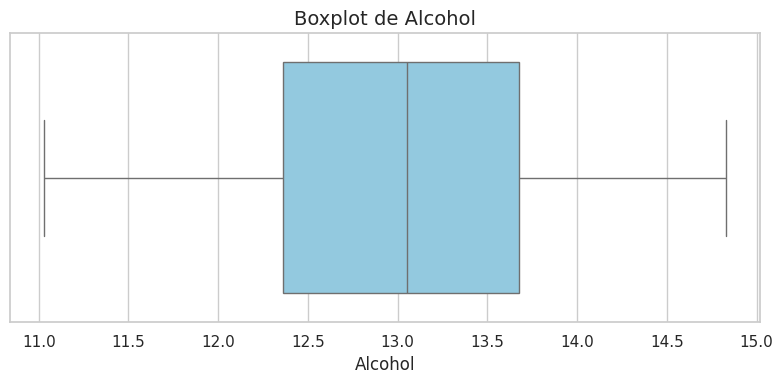

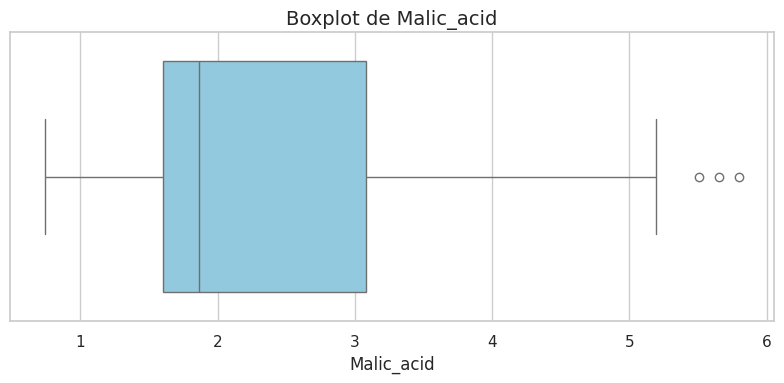

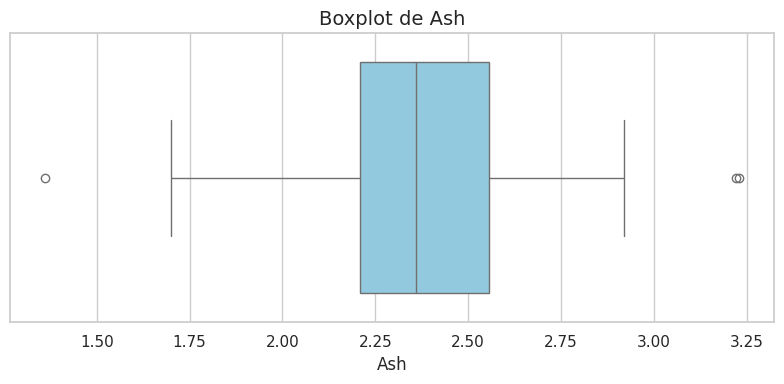

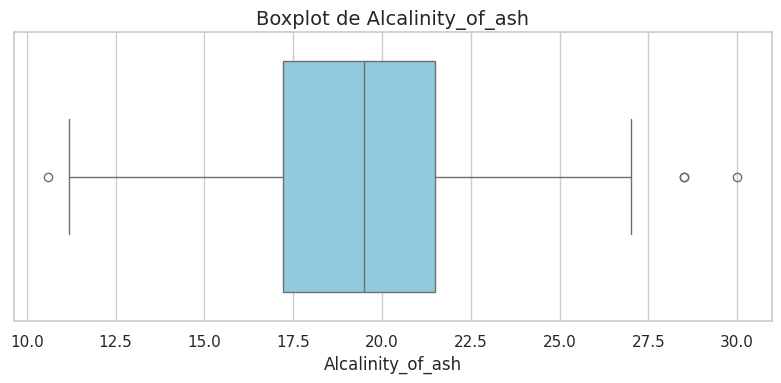

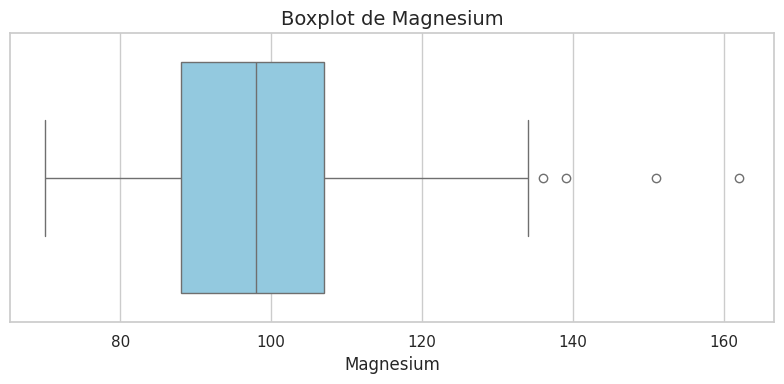

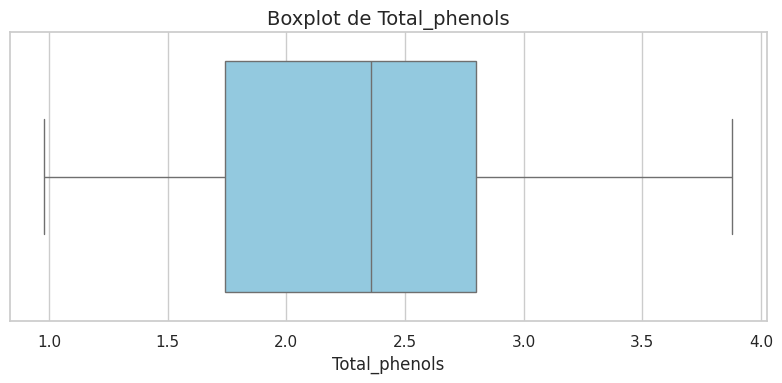

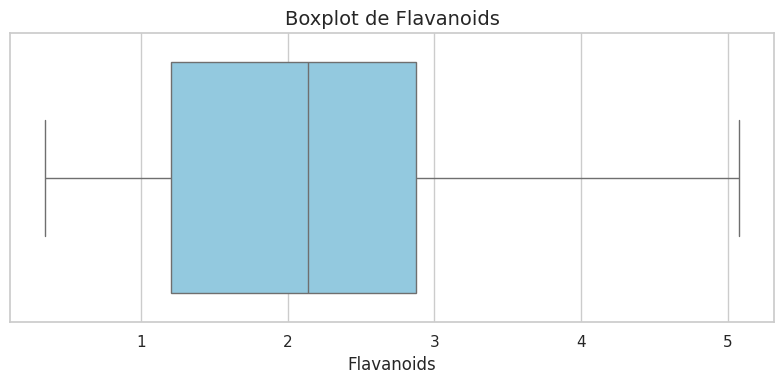

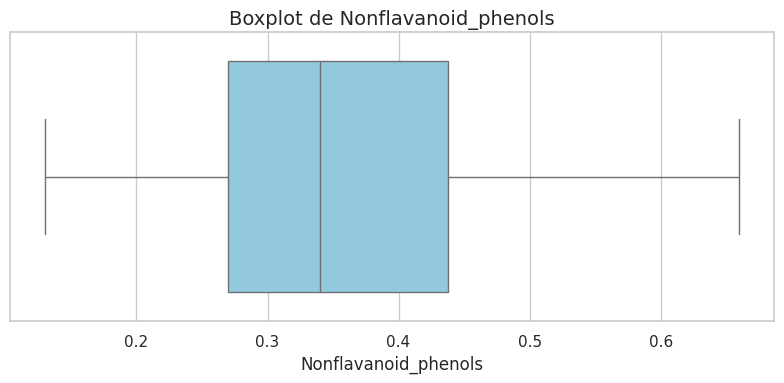

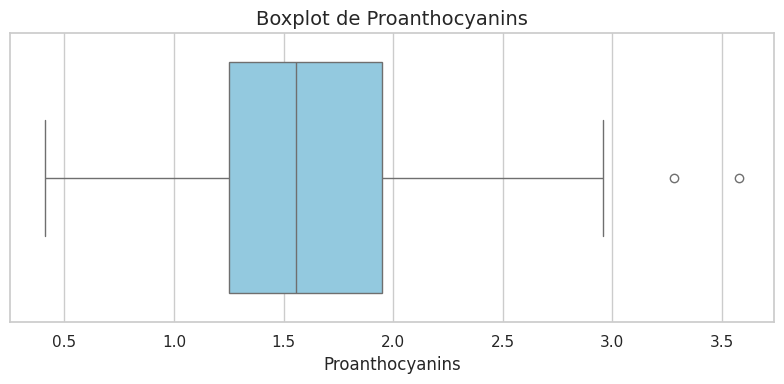

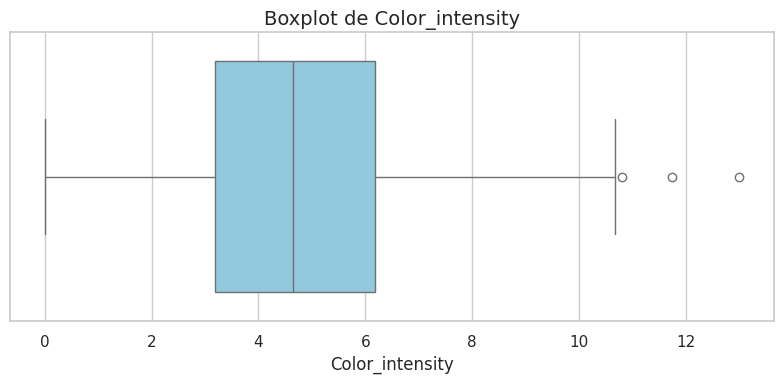

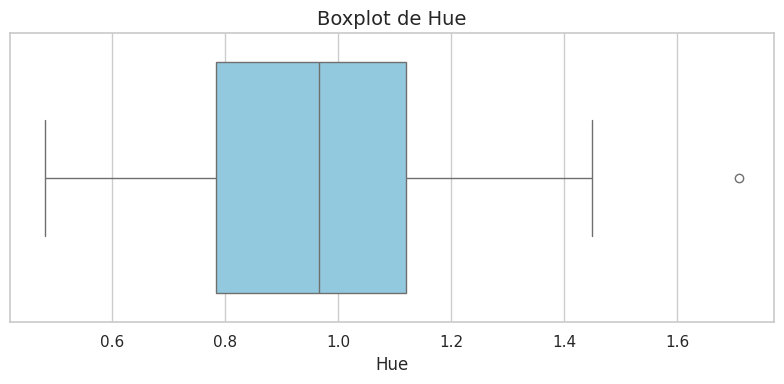

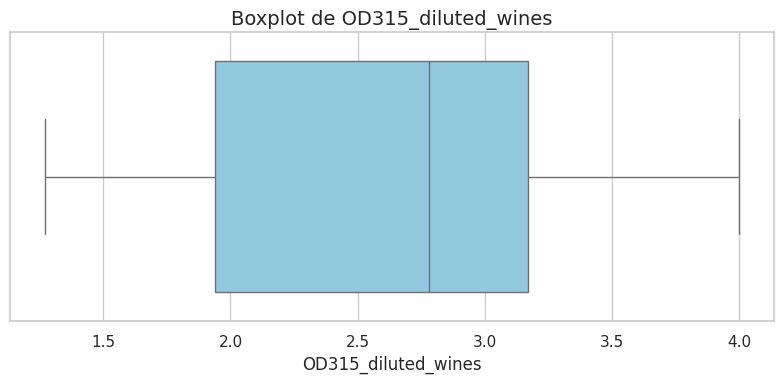

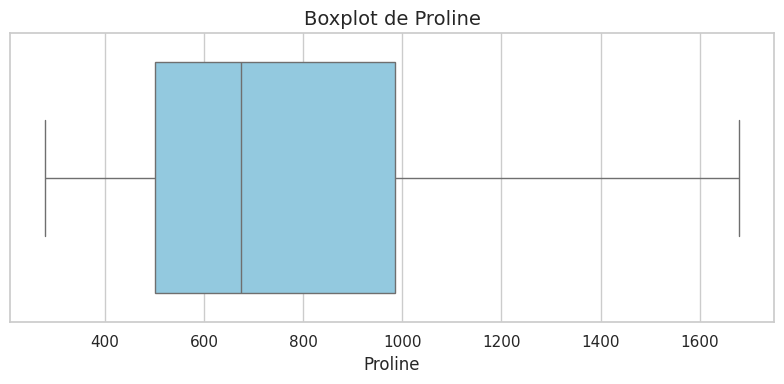

In [19]:
# Seleccionar las columnas numéricas
numeric_columns = [
    'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash', 'Magnesium',
    'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins',
    'Color_intensity', 'Hue', 'OD315_diluted_wines', 'Proline'
]

# Convertir a un DataFrame de Pandas
df_pandas = df.select(numeric_columns).toPandas()

# Configuración general del estilo
sns.set(style="whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})  # Evitar advertencias por muchas gráficas

# Iterar sobre cada columna y generar un boxplot individual
for column in df_pandas.columns:
    plt.figure(figsize=(8, 4))  # Tamaño de la figura
    sns.boxplot(data=df_pandas, x=column, color="skyblue")
    
    # Título y etiquetas
    plt.title(f"Boxplot de {column}", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.tight_layout()
    
    # Mostrar la gráfica
    plt.show()

In [20]:
# Seleccionar las columnas numéricas
numeric_columns = [
    'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash', 'Magnesium',
    'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins',
    'Color_intensity', 'Hue', 'OD315_diluted_wines', 'Proline'
]

# Crear una lista para almacenar los resultados
outliers_df = df

# Calcular Q1, Q3 e IQR para cada columna
for col in numeric_columns:
    # Calcular Q1 y Q3
    quantiles = outliers_df.approxQuantile(col, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    
    # Calcular los límites inferior y superior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Agregar una columna para identificar si un valor es un outlier
    outliers_df = outliers_df.withColumn(
        f"{col}_is_outlier",
        F.when((F.col(col) < lower_bound) | (F.col(col) > upper_bound), 1).otherwise(0)
    )

In [21]:
# Sumar los outliers para cada columna
for col in numeric_columns:
    outlier_col = f"{col}_is_outlier"
    count_outliers = outliers_df.filter(F.col(outlier_col) == 1).count()
    print(f"Columna {col}: {count_outliers} outliers detectados")

Columna Alcohol: 0 outliers detectados
Columna Malic_acid: 4 outliers detectados
Columna Ash: 5 outliers detectados
Columna Alcalinity_of_ash: 4 outliers detectados
Columna Magnesium: 4 outliers detectados
Columna Total_phenols: 0 outliers detectados
Columna Flavanoids: 0 outliers detectados
Columna Nonflavanoid_phenols: 0 outliers detectados
Columna Proanthocyanins: 2 outliers detectados
Columna Color_intensity: 3 outliers detectados
Columna Hue: 1 outliers detectados
Columna OD315_diluted_wines: 0 outliers detectados
Columna Proline: 0 outliers detectados


In [22]:
# Filtrar registros con al menos un outlier
columns_outlier_flags = [f"{col}_is_outlier" for col in numeric_columns]
outlier_records = outliers_df.filter(
    F.expr(" OR ".join([f"{col} = 1" for col in columns_outlier_flags]))
)

# outlier_records.show()

In [23]:
# Crear una condición para filtrar registros sin outliers
condition_no_outliers = " AND ".join([f"{col} = 0" for col in columns_outlier_flags])

# Filtrar el DataFrame eliminando los registros con outliers
df_without_outliers = outliers_df.filter(F.expr(condition_no_outliers))

# Mostrar el resultado después de eliminar los outliers
print(f"Total de registros sin outliers: {df_without_outliers.count()}")
# df_without_outliers.show()

Total de registros sin outliers: 159


### Verificar la eliminacion de Outliers

In [24]:
# Seleccionar las columnas numéricas
numeric_columns = [
    'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash', 'Magnesium',
    'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins',
    'Color_intensity', 'Hue', 'OD315_diluted_wines', 'Proline'
]

# Crear una lista para almacenar los resultados
outliers_df = df_without_outliers

# Calcular Q1, Q3 e IQR para cada columna
for col in numeric_columns:
    # Calcular Q1 y Q3
    quantiles = outliers_df.approxQuantile(col, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    
    # Calcular los límites inferior y superior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Agregar una columna para identificar si un valor es un outlier
    outliers_df = outliers_df.withColumn(
        f"{col}_is_outlier",
        F.when((F.col(col) < lower_bound) | (F.col(col) > upper_bound), 1).otherwise(0)
    )

In [25]:
# Sumar los outliers para cada columna
for col in numeric_columns:
    outlier_col = f"{col}_is_outlier"
    count_outliers = outliers_df.filter(F.col(outlier_col) == 1).count()
    print(f"Columna {col}: {count_outliers} outliers detectados")

Columna Alcohol: 0 outliers detectados
Columna Malic_acid: 0 outliers detectados
Columna Ash: 1 outliers detectados
Columna Alcalinity_of_ash: 2 outliers detectados
Columna Magnesium: 1 outliers detectados
Columna Total_phenols: 0 outliers detectados
Columna Flavanoids: 0 outliers detectados
Columna Nonflavanoid_phenols: 0 outliers detectados
Columna Proanthocyanins: 1 outliers detectados
Columna Color_intensity: 2 outliers detectados
Columna Hue: 0 outliers detectados
Columna OD315_diluted_wines: 0 outliers detectados
Columna Proline: 0 outliers detectados


In [26]:
## Conteo para ver como disminuyo el dataframe
print(df.count())
print(df_without_outliers.count())

178
159


In [27]:
df = df_without_outliers.select("*")
# df.show(10)

In [28]:
## Contamos la cantidade de ddistribucion de nuestra variable Target
df.groupBy('Target').count().show()

+------+-----+
|Target|count|
+------+-----+
|     1|   58|
|     2|   59|
|     3|   42|
+------+-----+



### Escalar columnas

In [29]:
def escalar_columnas(df, columna_excluir="Target"):
    """
    Escala las columnas numéricas de un DataFrame, excluyendo la columna especificada.

    Args:
        df (pd.DataFrame): DataFrame a escalar.
        columna_excluir (str): Nombre de la columna que no se escalará.

    Returns:
        pd.DataFrame: DataFrame con las columnas seleccionadas escaladas.
    """
    # convierte a pandas
    df = df.toPandas()
    # Seleccionar las columnas a escalar
    columnas_escala = [col for col in df.columns if col != columna_excluir]
    
    # Crear un objeto StandardScaler
    scaler = StandardScaler()
    
    # Escalar las columnas seleccionadas
    df[columnas_escala] = scaler.fit_transform(df[columnas_escala])
        # convertimos a spark
    df = spark.createDataFrame(df)
    print("Columnas escaladas excluyendo:", columna_excluir)
    return df

In [30]:
df_escalado = escalar_columnas(df, columna_excluir="Target")

Columnas escaladas excluyendo: Target


### Grafico de matriz de correlación entre variables y target

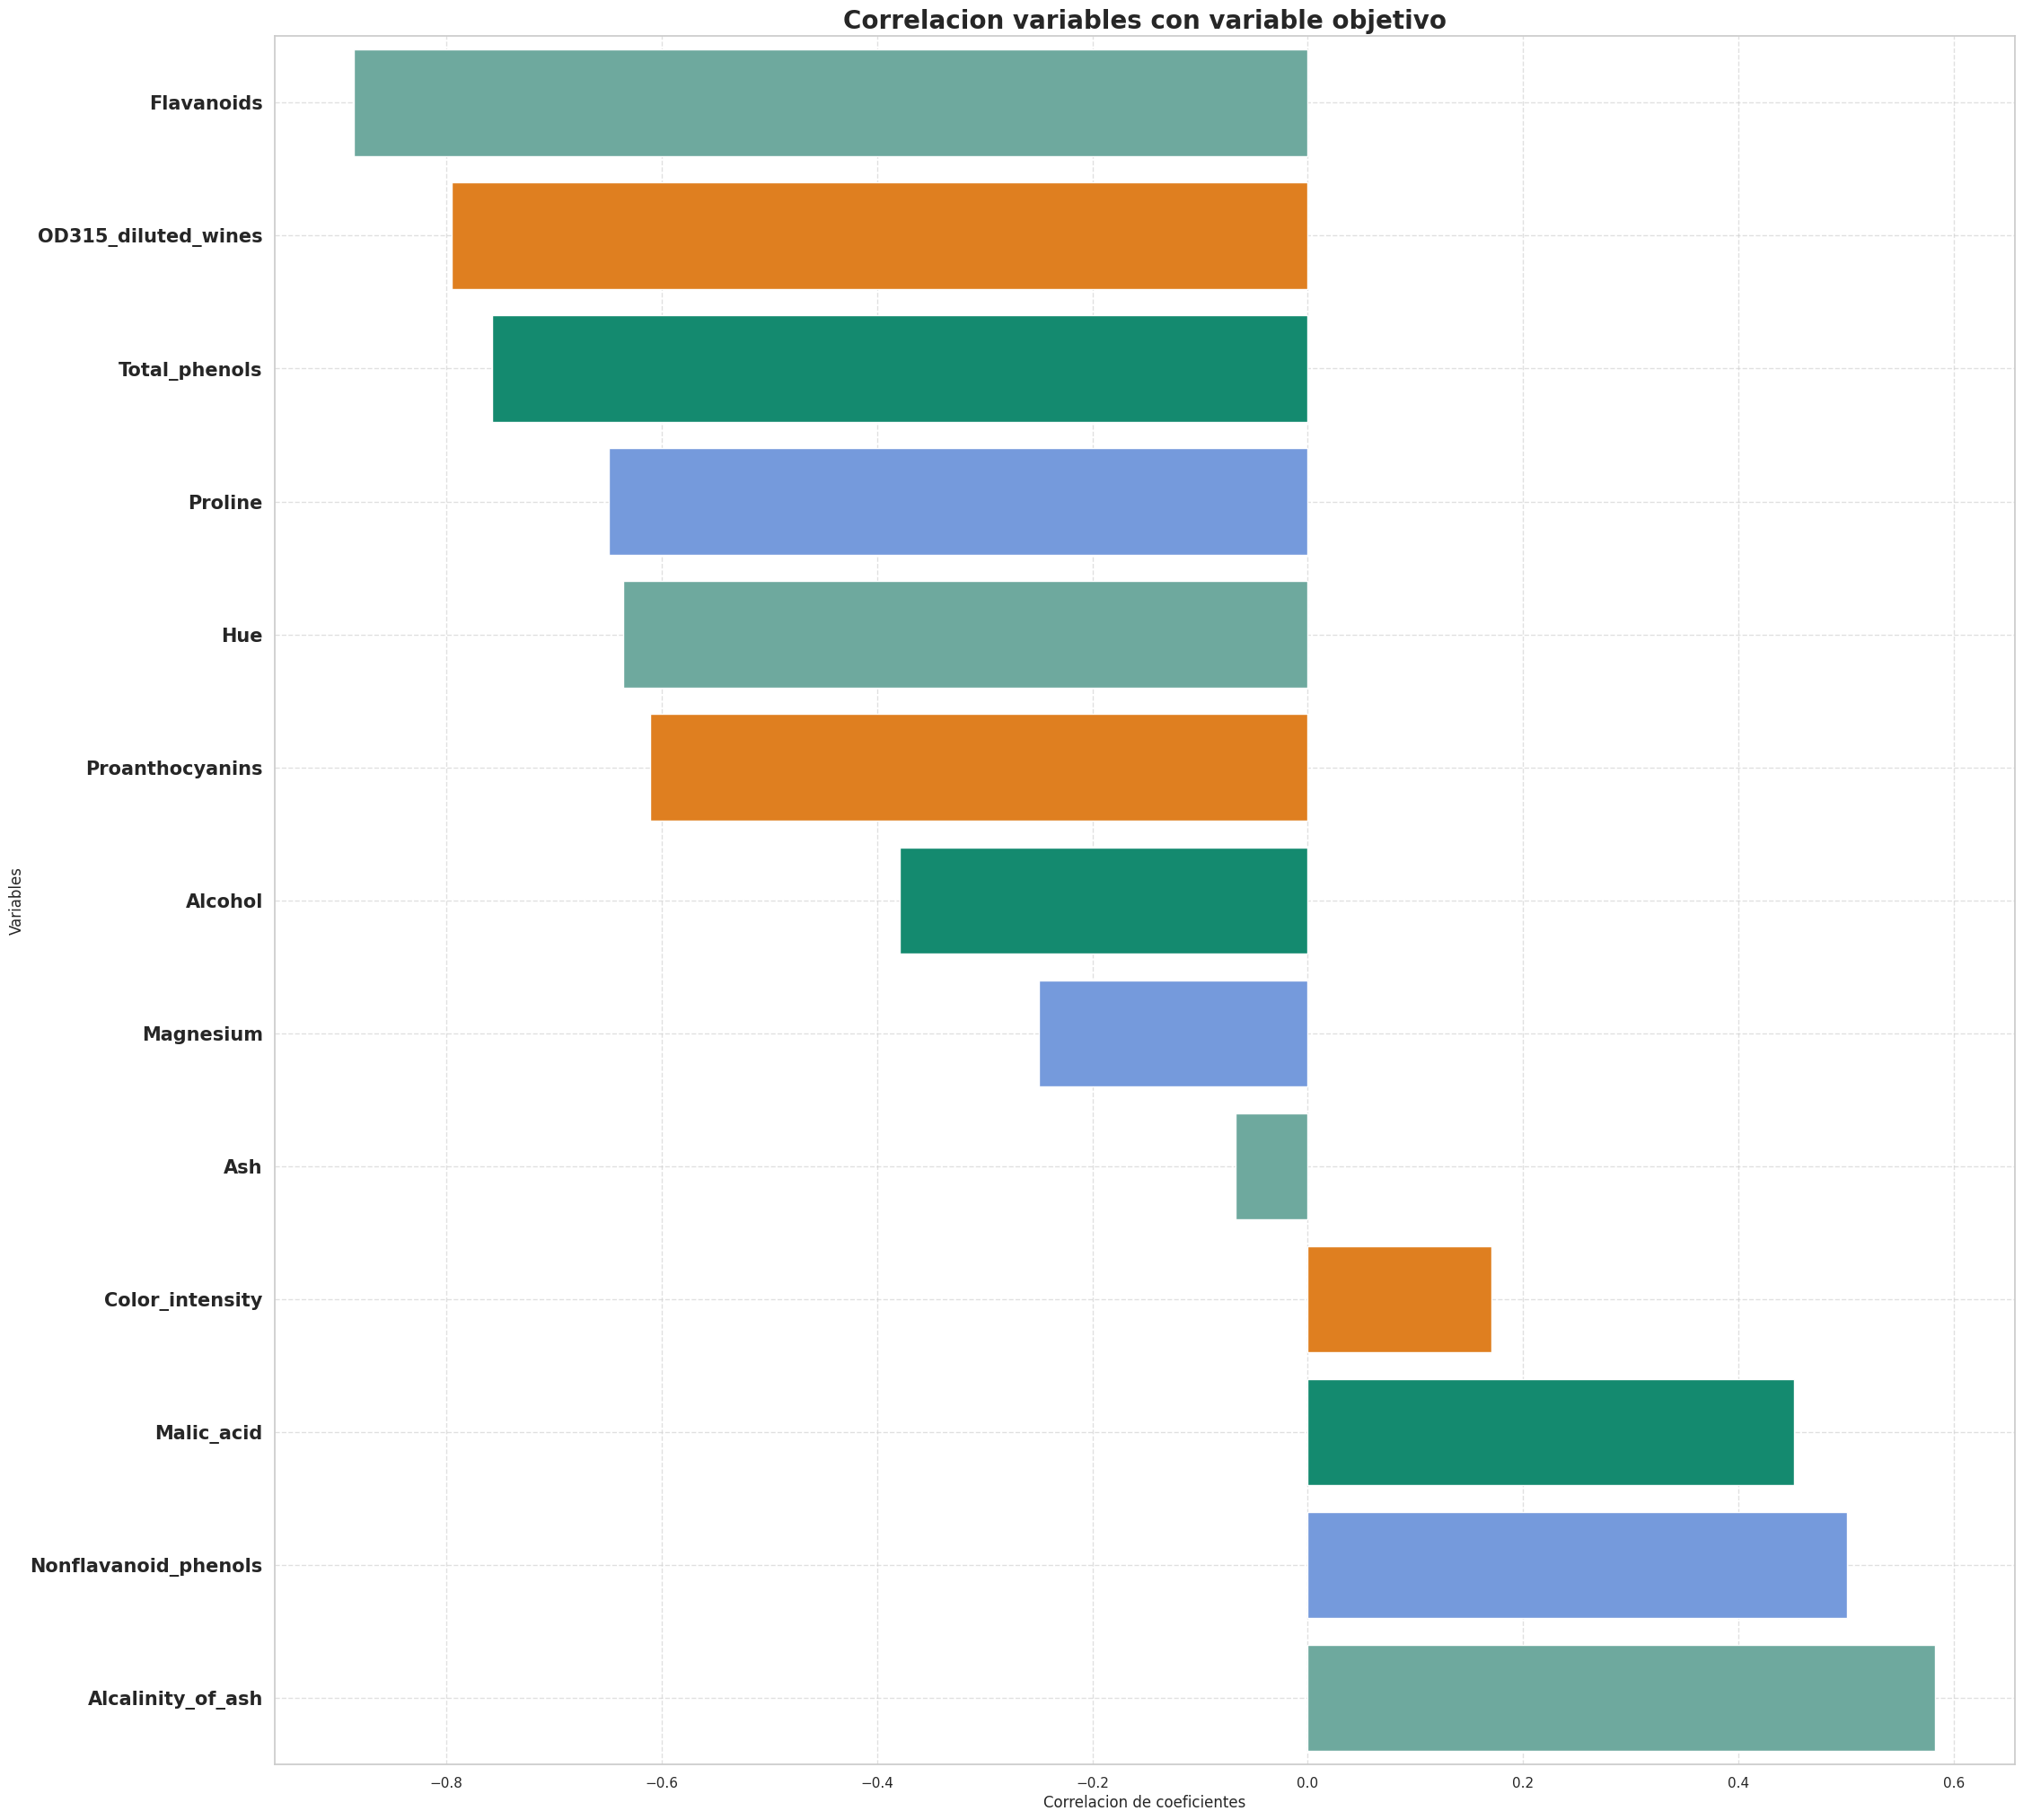

In [31]:
# Grafico de matriz de correlación entre variables y target 
# df_escalado = df_escalado.toPandas()
FN_PLOT_VARIABLES_CORRELACION_CON_TARGET(df_escalado.toPandas(), target_column="Target")

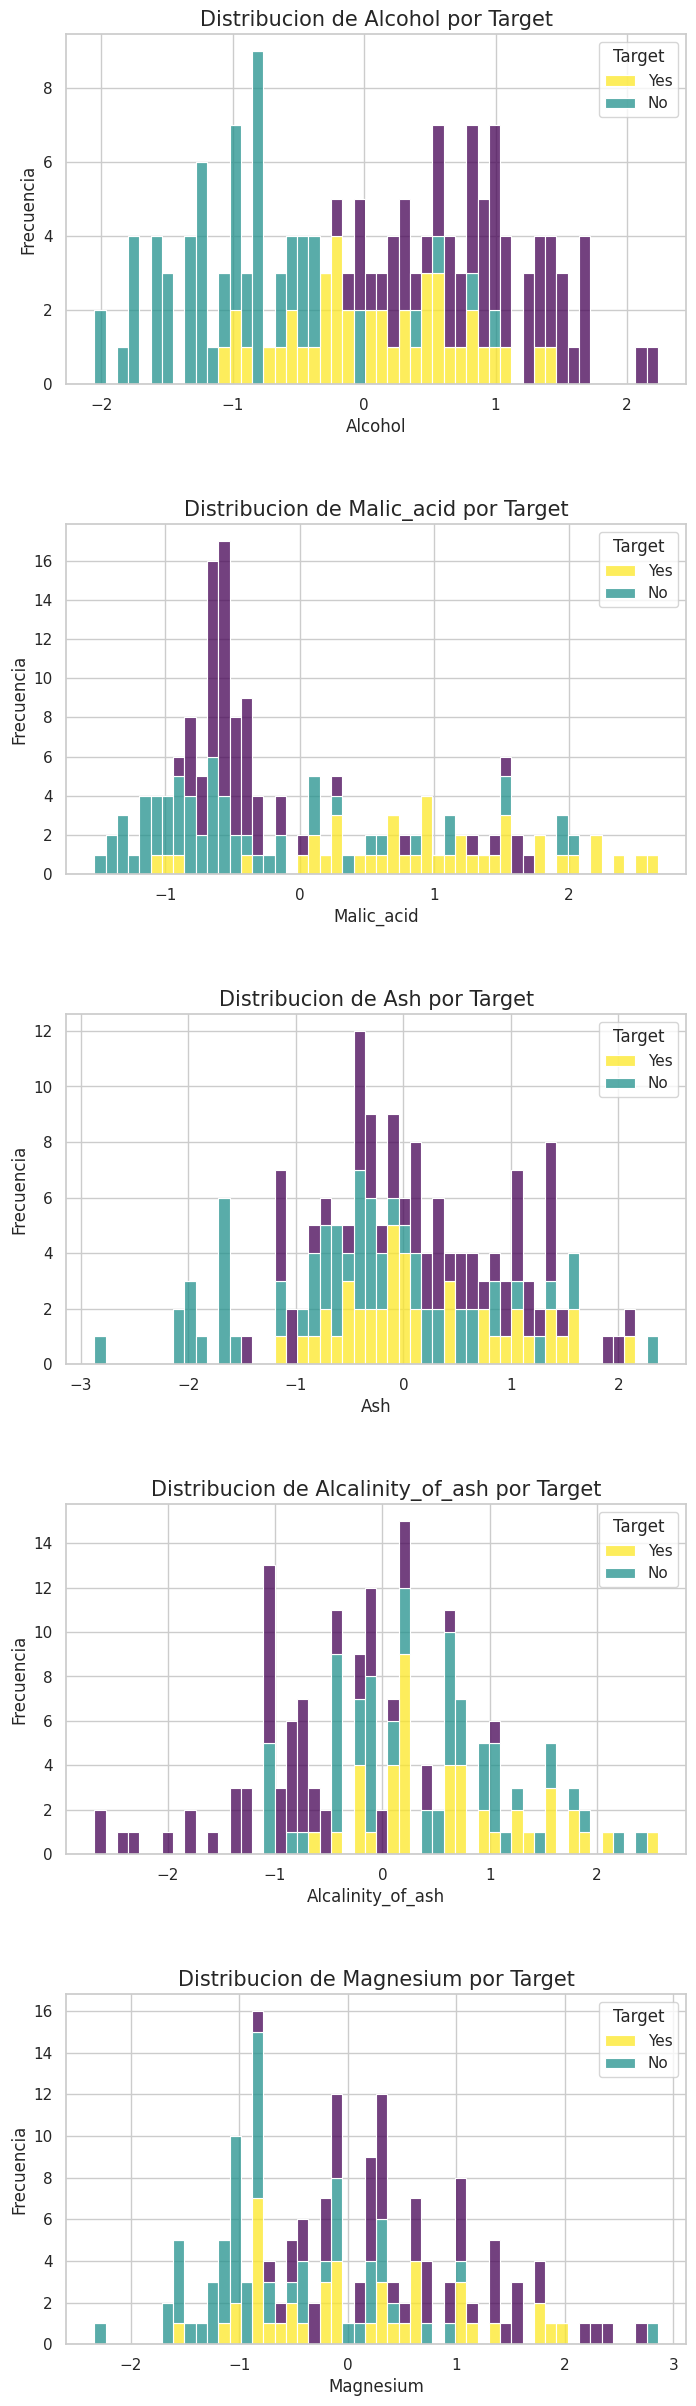

In [32]:
# vamos a revisar la ditribucion de las siguiente variables 'renta_t1', 'antiguedad', 'estabilidad_renta'
FN_PLOT_VARIABLE_DISTRIBUCION_POR_TARGET(df_escalado.toPandas(), ['Alcohol',
 'Malic_acid',
 'Ash',
 'Alcalinity_of_ash',
 'Magnesium',], target_column="Target")


In [33]:
# Eliminar la columna 'Ash' porque aporta menos de 1% a la implementacion de la variable Target
df_escalado = df_escalado.drop('Ash')

In [34]:
df_escalado.show()

+------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+---------------------+--------------+----------------------------+--------------------+------------------------+---------------------+-------------------------------+--------------------------+--------------------------+--------------+------------------------------+------------------+
|Target|            Alcohol|          Malic_acid|   Alcalinity_of_ash|           Magnesium|      Total_phenols|         Flavanoids|Nonflavanoid_phenols|     Proanthocyanins|    Color_intensity|                 Hue| OD315_diluted_wines|            Proline|Alcohol_is_outlier|Malic_acid_is_outlier|Ash_is_outlier|Alcalinity_of_ash_is_outlier|Magnesium_is_outlier|Total_phenols_is_outlier|Flavanoids_is_outlier|Nonflavanoid_phenols_is_outlier|

In [35]:
df_escalado.groupBy('Target').count().show()

+------+-----+
|Target|count|
+------+-----+
|     1|   58|
|     2|   59|
|     3|   42|
+------+-----+



### Vectorizamos

In [37]:
from pyspark.ml.feature import VectorAssembler
## vectorizamos porque en pyspark recibe vectores no columnas
# if "features" in df_escalado.columns:
#     df_escalado = df_escalado.drop("features")

assembler = VectorAssembler(inputCols=['Alcohol', 'Malic_acid', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins',
 'Color_intensity', 'Hue', 'OD315_diluted_wines', 'Proline'], outputCol="features")
df_escalado = assembler.transform(df_escalado)
df_escalado.show(5)

+------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+---------------------+--------------+----------------------------+--------------------+------------------------+---------------------+-------------------------------+--------------------------+--------------------------+--------------+------------------------------+------------------+--------------------+
|Target|            Alcohol|          Malic_acid|   Alcalinity_of_ash|          Magnesium|     Total_phenols|        Flavanoids|Nonflavanoid_phenols|    Proanthocyanins|    Color_intensity|                 Hue|OD315_diluted_wines|            Proline|Alcohol_is_outlier|Malic_acid_is_outlier|Ash_is_outlier|Alcalinity_of_ash_is_outlier|Magnesium_is_outlier|Total_phenols_is_outlier|Flavanoids_is_outlier|Nonflavanoid_phenols_

In [38]:
df_escalado.select('Target','features').tail(10)

[Row(Target=3, features=DenseVector([-0.2856, 1.035, 0.0744, -0.8751, -1.2752, -1.4026, 0.3475, -1.0947, 2.4496, -1.1043, -1.233, -0.2339])),
 Row(Target=3, features=DenseVector([0.6676, 0.2658, 1.7362, 0.5041, -1.1645, -1.2194, 0.2643, -0.0073, 1.7076, -1.0114, -1.1625, -0.0335])),
 Row(Target=3, features=DenseVector([0.4418, 2.2326, 1.9023, 1.0721, -0.4843, -1.0972, -0.7342, -0.8276, 1.6333, -1.3366, -0.9931, -0.4036])),
 Row(Target=3, features=DenseVector([-1.0633, 0.7039, -0.0918, -0.226, -1.639, -1.5757, 0.3475, -1.5525, 0.2419, -1.383, -1.1201, -0.7736])),
 Row(Target=3, features=DenseVector([-0.3484, 0.0808, 0.0744, -1.0374, -1.4176, -1.5553, 1.0131, -1.7242, -2.309, -1.8011, -1.4024, -0.897])),
 Row(Target=3, features=DenseVector([1.3951, 0.1976, 0.2406, -0.6317, -0.9588, -1.3619, 0.6803, -0.5796, 2.1899, -1.5689, -1.2895, -0.311])),
 Row(Target=3, features=DenseVector([0.4418, 1.5608, 1.2376, 0.2607, -0.769, -1.311, 0.5971, -0.2553, 1.0768, -1.1972, -1.5011, -0.0335])),
 Row(T

## Guardar el archivo en parquet

In [39]:
# Ruta donde deseas guardar el archivo Parquet
output_path = "output_data/DATA_VINOS_PREPROCESAMIENTO.parquet"
# os.makedirs(output_path, exist_ok=False)
# Guardar el DataFrame como archivo Parquet
df_escalado.write.parquet(output_path, mode="overwrite")
print(f"Archivo Parquet guardado en: {output_path}")

Archivo Parquet guardado en: output_data/DATA_VINOS_PREPROCESAMIENTO.parquet
